# Optimization and Topological Data Analysis

Mathieu Carrière, https://mathieucarriere.github.io/website/

In this notebook, we are going to see how to combine Gudhi and Tensorflow in order to do persistence optimization!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd
import tensorflow as tf
from tensorflow.python.framework import ops
import pandas as pd

This function is a simple wrapper that turns python functions into Tensorflow operations. We will use it in the rest of this notebook.

In [2]:
def py_func(func, inp, Tout, stateful=True, name=None, grad=None):
    rnd_name = "PyFuncGrad" + str(np.random.randint(0, 1e+8))
    tf.RegisterGradient(rnd_name)(grad)
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)

## Point cloud optimization

You might have already seen a few examples of persistence diagram computations on point clouds. Among the different possibilities, the Rips filtration is the most common option due to its simplicity and easy implementation. In this notebook, we will see how Gudhi and Tensorflow can be combined to perform optimization of persistence diagrams.

Let's have a quick refresher ;-)

First, let's generate a random point cloud in the unit square and visualize it.

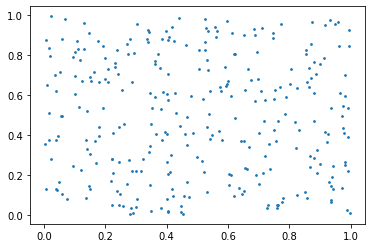

In [3]:
X = np.random.uniform(size=[300,2])
plt.scatter(X[:,0], X[:,1], s=3)
plt.show()

Yep, looks pretty random indeed. Let's now compute its Rips persistence diagram. This is literally two lines of code with Gudhi :-)

In [4]:
st = gd.RipsComplex(points=X, max_edge_length=1.).create_simplex_tree(max_dimension=2)
dgm = st.persistence()

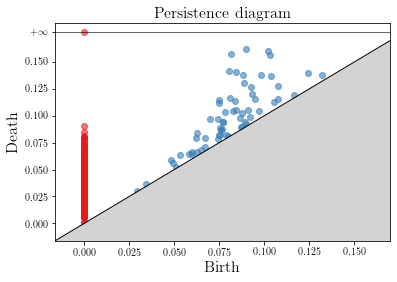

In [5]:
plot = gd.plot_persistence_diagram(dgm)

As usual, there is one point (in dimension 0) at $+\infty$ which represents the whole connected component, a bunch of points in dimension 0 with abscissa 0 (actually, as many as there are points in the initial point cloud), and some points in dimension 1. There is nothing else because we only kept the 2-skeleton of the Rips complex in the previous cell.

This is great. But have you ever thought about the inverse problem? That is, can you tweak the point cloud so that the corresponding persistence diagram satisfies some properties? That sounds hard. Turns out it is not if you combine Gudhi and Tensorflow ;-)

Before jumping to the code, let's think about what's happening here. If you think about how persistence is computed, the coordinates of any point $p$ in a persistence diagram are actually given by the filtration values of two very specific simplices: the so-called positive and negative simplices of $p$, denoted by $\sigma_+(p)$ and $\sigma_-(p)$ (check chapter VII.1 in [this reference book](https://books.google.com/books/about/Computational_Topology.html?id=MDXa6gFRZuIC) for more details if you feel lost). So, we have: $$p=(f(\sigma_+(p)), f(\sigma_-(p))),$$
where $f$ is the filtration function. This means that if $f$ is actually defined by some parameters $f = f_\theta$, then the gradient $\nabla_\theta p$ is actually given by $\nabla_\theta f_\theta(\sigma_+(p))$ and $\nabla_\theta f_\theta(\sigma_-(p))$.

Interesting, but how does this look like for the Rips filtration? Well, first, the parameters $\theta$ are now the positions of the points in the point cloud. Second, as you may recall, the filtration value of any simplex is simply the maximal distance between any two vertices in the simplex: $f(\{v_0,\cdots, v_n\})=\|v_a-v_b\|$, $0\leq a,b\leq n$, where $\|v_a-v_b\|\geq \|v_i-v_j\|$, $\forall 0\leq i,j \leq n$. The gradient of $f$ thus only depends on the positions of $v_a$ and $v_b$: $\nabla f=\frac{v_a-v_b}{\|v_a-v_b\|}$. You can check [this article](https://arxiv.org/abs/1506.03147) for more details.

All right! So the only thing that remains to do is to compute the positive and negative simplices, right? Turns out that Gudhi can do that with the `persistence_pairs()` function. Well, let's go then!

Let's first write a function that computes these positive and negative simplices in addition to the persistence diagram for a given simplex tree.

In [6]:
def compute_persistence(st, card, hom_dim):
    st.persistence()
    pairs = st.persistence_pairs()
    dgm = np.zeros([card[0], 2], dtype=np.float32)
    spl = np.zeros([card[0], 2*hom_dim[0] + 3], dtype=np.int32)
    mask = np.zeros([card[0]], dtype=np.int32)
    count = 0
    for [splx0, splx1] in pairs:
        if len(splx0) - 1 == hom_dim[0] and count < card[0] and len(splx1) > 0:
            dgm[count,0], dgm[count,1] = st.filtration(splx0), st.filtration(splx1)
            spl[count,:hom_dim[0]+1], spl[count,hom_dim[0]+1:] = np.array(splx0), np.array(splx1)
            mask[count] = 1
            count += 1
    return [dgm, spl, mask]

Since we want to use Tensorflow eventually for doing the optimization, the persistence diagram must have a predefinite size, that we provide with the parameter `card`. We are going to keep the `card` points that are the furthest away from the diagonal. We also specify the homological dimension with `hom_dim`. Note that we also output a variable `mask`, which tells you if a point in the persistence diagram is real, or just a dummy point that we added because the diagram had less than `card` points.

Let's now write a wrapper for the Rips filtration. `x` contains the point positions (our parameters!), `Dx` is the matrix of pairwise distances, and `max_length` is the maximal length in the Rips filtration.

In [7]:
def compute_rips(card, hom_dim, x, Dx, max_length):
    rc = gd.RipsComplex(points=x, max_edge_length=max_length[0])
    st = rc.create_simplex_tree(max_dimension=hom_dim[0]+1)
    return compute_persistence(st, card, hom_dim)

Here is now an implementation of the gradient for the Rips filtration defined above.

In [8]:
def compute_rips_grad(grad_dgm, dgm, spl, mask, c, h, x, Dx):
    grad_x = np.zeros(x.shape, dtype=np.float32)
    for i in range(c[0]):
        if mask[i] == 1:
            val0, val1 = dgm[i,0], dgm[i,1]
            splx0, splx1 = spl[i,:h[0]+1], spl[i,h[0]+1:]
            D0, D1 = Dx[splx0,:][:, splx0], Dx[splx1,:][:, splx1]
            [v0a, v0b] = list(splx0[np.argwhere(np.abs(D0-val0) <= 1e-4)[0,:]])
            [v1a, v1b] = list(splx1[np.argwhere(np.abs(D1-val1) <= 1e-4)[0,:]])
            if h[0] > 0:
                grad_x[v0a,:] += grad_dgm[i,0] * (x[v0a,:] - x[v0b,:]) / val0
                grad_x[v0b,:] += grad_dgm[i,0] * (x[v0b,:] - x[v0a,:]) / val0
            grad_x[v1a,:] += grad_dgm[i,1] * (x[v1a,:] - x[v1b,:]) / val1
            grad_x[v1b,:] += grad_dgm[i,1] * (x[v1b,:] - x[v1a,:]) / val1
    return grad_x

Note that, in order to save time for deciding who are the $v_a$ and $v_b$'s in the simplex, we just take the first entry in the distance matrix of the simplex that is less than `1e-4` away from the filtration value. Also, we check the homological dimension, because if it is 0, then the filtration value of the positive simplex is going to be 0, which will cause trouble in the gradient computation if we are not careful.

We are getting close! The only thing that remains to do is to wrap these functions into Tensorflow operations.

In [9]:
def Rips(card, hom_dim, x, Dx, max_length, name=None):
    with ops.op_scope([x], name, "Rips") as name:
        return py_func(compute_rips, [card, hom_dim, x, Dx, max_length], [tf.float32, tf.int32, tf.int32], \
                       name=name, grad=_RipsGrad)

def _RipsGrad(op, grad_dgm, grad_spl, grad_mask):
    dgm, spl, mask, c, h = op.outputs[0], op.outputs[1], op.outputs[2], op.inputs[0], op.inputs[1]
    x, Dx = op.inputs[2], op.inputs[3]
    grad_x = tf.py_func(compute_rips_grad, [grad_dgm, dgm, spl, mask, c, h, x, Dx], [tf.float32])[0]
    return [None, None, grad_x, None, None]

Finally, we are done! Let's define our parameters.

In [10]:
n_pts = 300   # number of points in the point clouds
card  = 50    # max number of points in the diagrams
hom   = 1     # homological dimension
ml    = 12.   # max distance in Rips
lr    = 1e-1  # learning rate

We initialize Tensorflow.

In [11]:
tf.reset_default_graph()

We randomly initalize our point cloud.

In [12]:
x = tf.get_variable("X", shape=[n_pts,2], initializer=tf.random_uniform_initializer(0.,1.), trainable=True)

Now we compute pairwise distances and persistence in the neural network.

In [13]:
x1, x2 = tf.reshape(x, [n_pts,1,2]), tf.reshape(x, [1,n_pts,2])
D = tf.sqrt(tf.reduce_sum(tf.square(x1-x2), axis=2))
dgm, spl, mask = Rips(tf.constant(np.array([card],dtype=np.int32)),\
                      tf.constant(np.array([hom],dtype=np.int32)), x,D,\
                      tf.constant(np.array([ml],dtype=np.float32)))

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


Our loss is the opposite of the sum of squares of the distances to the diagonal of the points in the diagram. This will force the persistence diagram to have many prominent points, and thus the point cloud will contain as much loops as possible.

In [14]:
loss = -tf.reduce_sum(tf.square(dgm[:,1]-dgm[:,0]))

We use standard gradient descent for the optimization.

In [15]:
opt = tf.train.GradientDescentOptimizer(learning_rate=lr)
train = opt.minimize(loss)

Let's train  and visualize the point cloud every 10 iterations, or epochs!

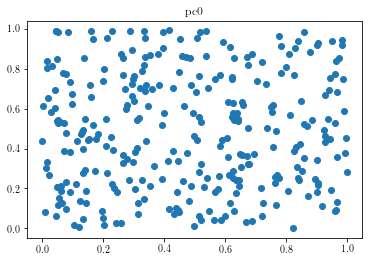

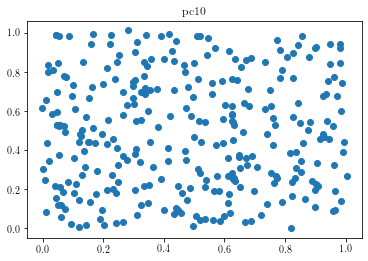

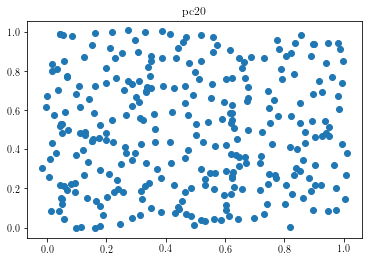

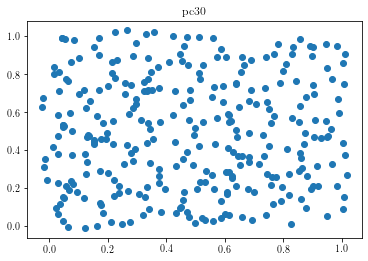

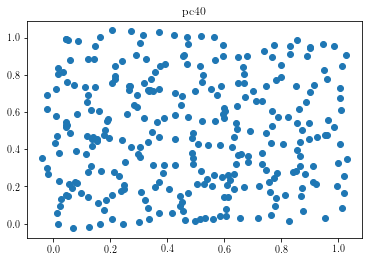

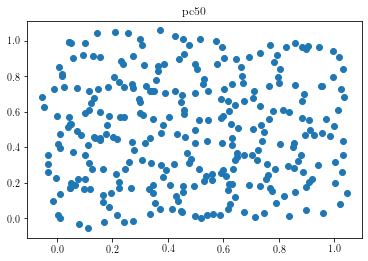

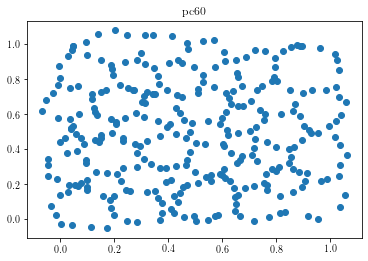

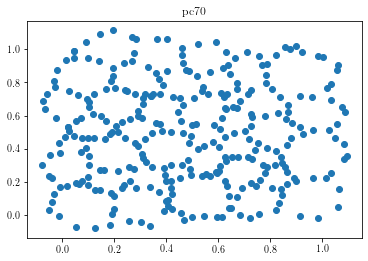

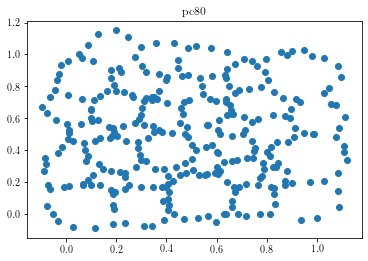

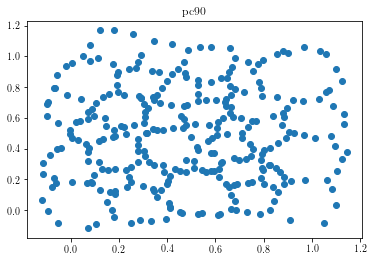

In [16]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(100):
        if (epoch % 10 == 0):
            X = sess.run(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "X")[0])
            plt.figure()
            plt.scatter(X[:,0], X[:,1])
            plt.title("pc" + str(epoch))
            plt.show()
        sess.run(train)

Looks like there are more cycles indeed ;-)

## Image optimization

We can actually play the same game with images! Indeed, Gudhi contains code for computing [cubical persistence](http://www2.im.uj.edu.pl/mpd/publications/Wagner_persistence.pdf), which is very well-suited for handling images. For instance, it can be used to filter a 2D image with its pixel values. Overall, the optimization follows the exact same steps as before, except that we use pixel filtration instead of Rips filtration. This means that the parameters $\theta$ that we are now going to optimize are the pixel values themselves, and that the gradients for positive simplex $\nabla_\theta f_\theta(\sigma_+(p))$ and negative simplex $\nabla_\theta f_\theta(\sigma_-(p))$ now simply equal $1$ for the pixels associated to $\sigma_+(p)$ and $\sigma_-(p)$ and $0$ for all other pixels.

Fortunately, Gudhi contains a function `cofaces_of_persistence_pairs()` that exactly retrieves the pixels (or, more formally, the cofaces) of the positive and negative simplices of a persistence point $p$.

Let's start with a function that computes those pixels.

In [17]:
def compute_cubical(card, hom_dim, x):
    cc = gd.CubicalComplex(dimensions = x.shape, top_dimensional_cells=x.flatten())
    cc.persistence()
    cof = cc.cofaces_of_persistence_pairs()[0][hom_dim[0]]
    dgm = np.zeros([card[0], 2], dtype=np.float32)
    spl = np.zeros([card[0], 2], dtype=np.int32)
    mask = np.zeros([card[0]], dtype=np.int32)
    count = 0
    for i in range(len(cof)):
        splx0, splx1 = cof[i,0], cof[i,1]
        if count < card[0]:
            dgm[count,0], dgm[count,1] = x.flat[splx0], x.flat[splx1]
            spl[count,0], spl[count,1] = splx0, splx1
            mask[count] = 1
            count += 1
    return dgm, spl, mask

`mask`, `card` and `hom_dim` are variables required by Tensorflow, so that persistence diagrams have predefinite sizes (see previous section of this notebook). Here is now an implementation for the gradient defined above.

In [18]:
def compute_cubical_grad(grad_dgm, dgm, spl, mask, c, h, x):
    grad_x = np.zeros(x.shape, dtype=np.float32)
    for i in range(c[0]):
        if mask[i] == 1:
            val0, val1 = dgm[i,0], dgm[i,1]
            splx0, splx1 = spl[i,0], spl[i,1]
            grad_x.flat[splx0] += 1 * grad_dgm[i,0]
            grad_x.flat[splx1] += 1 * grad_dgm[i,1]
    return grad_x

Finally, let's wrap these functions into Tensorflow operations.

In [19]:
def Cubical(card, hom_dim, x, name=None):
    with ops.op_scope([x], name, "Cubical") as name:
        return py_func(compute_cubical, [card, hom_dim, x], [tf.float32, tf.int32, tf.int32], name=name, grad=_CubicalGrad)
    
def _CubicalGrad(op, grad_dgm, grad_spl, grad_mask):
    dgm, spl, mask, c, h = op.outputs[0], op.outputs[1], op.outputs[2], op.inputs[0], op.inputs[1]
    x = op.inputs[2]
    grad_x = tf.py_func(compute_cubical_grad, [grad_dgm, dgm, spl, mask, c, h, x], [tf.float32])[0]
    return [None, None, grad_x]

All right! Let's apply all of these now! We are going to use the following image:

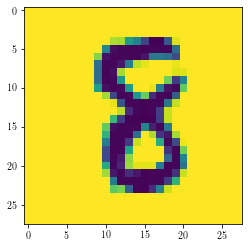

In [20]:
I = np.array(pd.read_csv("datasets/mnist_test.csv", header=None, sep=","), dtype=np.float32)
idx = np.argwhere(I[:,0] == 8)
image = np.reshape(-I[idx[8],1:], [28,28])
plt.figure()
plt.imshow(image)
plt.show()

As you can see, the upper loop of this 8 is not complete. Since it corresponds to 1-dimensional topology, we can fix this by optimizing the pixel values so that the points in the 1-dimensional persistence diagram have maximal persistence. 

We first define the network parameters.

In [21]:
card  = 50        # max number of points in the diagrams
hom   = 1         # homological dimension
lr    = 5 * 1e-2  # learning rate

We initialize Tensorflow.

In [22]:
tf.reset_default_graph()

We initialize the pixel values with the original image.

In [23]:
x = tf.get_variable("X", initializer=np.array(image), trainable=True)

Now we compute cubical persistence in the neural network.

In [24]:
dgm, spl, mask = Cubical(tf.constant(np.array([card],dtype=np.int32)),
                         tf.constant(np.array([hom],dtype=np.int32)),x)

Our loss is the same as in the previous section, that is, the opposite of the sum of squares of the distances to the diagonal of the points in the diagram.

In [25]:
loss = -tf.reduce_sum(tf.square(dgm[:,0]))

Gradient descent optimization.

In [26]:
opt = tf.train.GradientDescentOptimizer(learning_rate=lr)
train = opt.minimize(loss)

Let's train  and visualize the image every 10 iterations, or epochs!

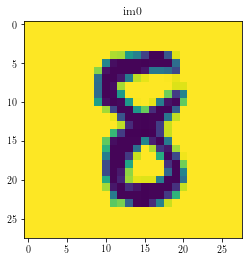

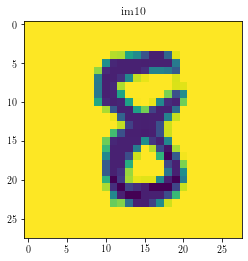

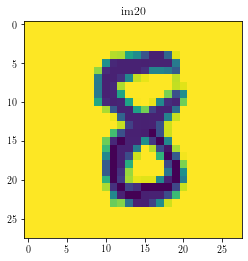

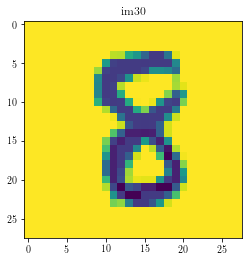

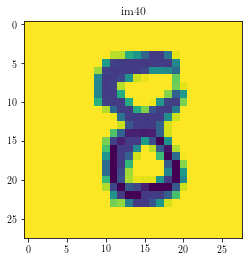

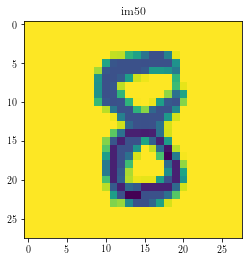

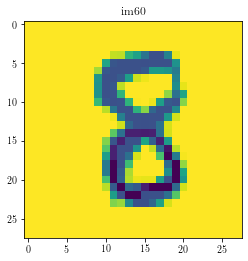

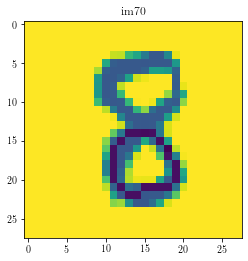

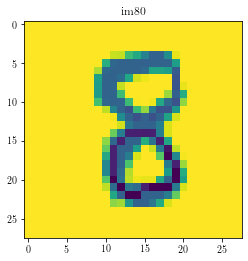

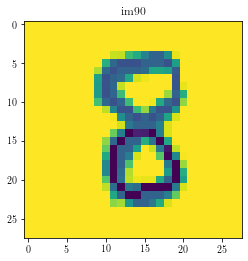

In [27]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(100):
        if (epoch % 10 == 0):
            X = sess.run(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "X")[0])
            plt.figure()
            plt.imshow(X)
            plt.title("im" + str(epoch))
            plt.show()
        sess.run(train)

This upper loop looks definitely fixed now! :-)